## Intro

In this post, I want to share my take on Deep Neural Networks (DNN) and how we can practically use Machine Learning, the big sibling of AI, in the finance world. It's interesting to note that even with all the data floating around in the trading industry, Machine Learning isn't as widespread as you'd think.

So, I've decided to dive into the world of implementing Machine Learning, specifically deep learning, covering everything from the basics to the latest algorithms in the market. I'll talk about simple DNNs, explore Recurrent Neural Networks (RNNs) for time-series data, and touch on Reinforcement Learning (RL).

Beyond the tech stuff, my goal with this series is to highlight that coding for data analytics is a bit like hitting the gym – it's all about consistent practice. So, I'll not only tackle how to use advanced ML/AI algorithms in the trading business but also level up your coding game.

## Load & Preprocess data

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [30]:
# load data

# option1: yfinance
import yfinance as yf

train = yf.download("AAPL", start="2020-01-01", end="2022-06-30")
test = yf.download("AAPL", start="2022-07-01", end="2023-12-31")
train.head()

# TODO: A functionto load data not just stock market but other asset data
# def stock_price_downloader(sym:str, start_date:str, end_data:str) -> pd.DataFrame:
#     pass

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,74.059998,75.150002,73.797501,75.087502,73.059418,135480400
2020-01-03,74.287498,75.144997,74.125000,74.357498,72.349152,146322800
2020-01-06,73.447502,74.989998,73.187500,74.949997,72.925629,118387200
2020-01-07,74.959999,75.224998,74.370003,74.597504,72.582649,108872000
2020-01-08,74.290001,76.110001,74.290001,75.797501,73.750252,132079200


In [31]:
#remove lookahead fautl by dropping and replace 'Close' by Adj Close
for data in (train, test):
    data.drop(columns=['Close'], inplace= True)
    data.rename(columns={'Adj Close':'Close'}, inplace=True)

Feature engineering stands out as a crucial aspect in the realm of ML/AI. It's often been seen as an art to figure out the right features to toss into the model. However, the advent of Neural Networks has made this task a breeze, as deep learning takes on the heavy lifting of feature selection and engineering.

As we journey deep into multiple hidden layers with DNN-based models, the magic unfolds. These models elegantly spread out initial features and allocate the right coefficients during the learning steps, mainly through backpropagation. With these robust models in play, all I, as the model designer, need to do is prep any potential indicator that could amp up the predictive powers of the model.

Now, about preparing those indicators—I've got a trusty helper function for that.

In [32]:
def add_lags(data, lags, window=20):
    """
    Adds lag features to the given DataFrame.

    Parameters:
    - data (pd.DataFrame): Input data.
    - lags (int): Number of lags to add for each feature.
    - window (int): Rolling window size for calculating additional features.

    Returns:
    - df: pd.DataFrame: Modified DataFrame with lag features added.
    - list: List of column names for the added lag features.
    """
    # List to store column names for added lag features
    cols = []

    df = data.copy()
    df.dropna(inplace=True)

    # Calculate daily log returns
    df["r"] = np.log(df["Close"] / df["Close"].shift(1))

    # Calculate additional features using rolling windows
    df["sma"] = df["Close"].rolling(window).mean()
    df["min"] = df["Close"].rolling(window).min()
    df["max"] = df["Close"].rolling(window).max()
    df["mom"] = df["r"].rolling(window).mean()
    df["vol"] = df["r"].rolling(window).std()

    df.dropna(inplace=True)

    # Create a binary column 'd' based on the sign of daily returns
    df["d"] = np.where(df["r"] > 0, 1, 0)

    # List of features to consider
    features = ["r", "sma", "min", "max", "mom", "vol"]

    for f in features:
        for lag in range(1, lags + 1):
            col = f"{f}_lag_{lag}"
            df[col] = df[f].shift(lag)
            cols.append(col)

    df.dropna(inplace=True)

    return df, cols

In [33]:
train_df, cols = add_lags(train, lags=5)
test_df, cols = add_lags(test, lags=5)

In [34]:
print(len(cols))
train_df[cols].head()

30


,r_lag_1,r_lag_2,r_lag_3,r_lag_4,r_lag_5,sma_lag_1,sma_lag_2,sma_lag_3,sma_lag_4,sma_lag_5,...,mom_lag_1,mom_lag_2,mom_lag_3,mom_lag_4,mom_lag_5,vol_lag_1,vol_lag_2,vol_lag_3,vol_lag_4,vol_lag_5
Date,,,,,,,,,,,,,,,,,,,,,
2020-02-07,0.011629,0.008121,0.032480,-0.002750,-0.045352,76.930101,76.662286,76.381821,76.150127,76.013544,...,0.003506,0.003722,0.003080,0.001853,0.001502,0.018692,0.018816,0.018877,0.017621,0.017786
2020-02-10,-0.013686,0.011629,0.008121,0.032480,-0.002750,77.065828,76.930101,76.662286,76.381821,76.150127,...,0.001770,0.003506,0.003722,0.003080,0.001853,0.018591,0.018692,0.018816,0.018877,0.017621
2020-02-11,0.004738,-0.013686,0.011629,0.008121,0.032480,77.211572,77.065828,76.930101,76.662286,76.381821,...,0.001894,0.001770,0.003506,0.003722,0.003080,0.018603,0.018591,0.018692,0.018816,0.018877
2020-02-12,-0.006052,0.004738,-0.013686,0.011629,0.008121,77.253027,77.211572,77.065828,76.930101,76.662286,...,0.000535,0.001894,0.001770,0.003506,0.003722,0.018110,0.018603,0.018591,0.018692,0.018816
2020-02-13,0.023470,-0.006052,0.004738,-0.013686,0.011629,77.439070,77.253027,77.211572,77.065828,76.930101,...,0.002388,0.000535,0.001894,0.001770,0.003506,0.018480,0.018110,0.018603,0.018591,0.018692


## TensorFlow Model Building

In this series, I'll leverage the power of TensorFlow to construct versatile NN models. TensorFlow provides a wealth of tools and flexibilities straight out of the box. To streamline experimentation with different deep learning architectures, I've designed a helper function. The parameters passed into these functions are primarily hyperparameters, allowing the model designer to fine-tune and observe the impact on performance.


In [35]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2, l1

In [36]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-4)

In [37]:
def create_dnn_model(
    hidden_layers=2,
    hidden_units=128,
    dropout=False,
    rate=0.3,
    regularize=False,
    reg=l2(0.0005),
    optimizer=optimizer,
    input_dim=len(cols),
):
    if not regularize:
        reg = None
    model = Sequential()
    model.add(
        Dense(
            hidden_units,
            input_dim=input_dim,
            activity_regularizer=reg,
            activation="relu",
        )
    )
    if dropout:
        model.add(Dropout(rate, seed=100))
    for _ in range(hidden_layers):
        model.add(Dense(hidden_units, activation="relu", activity_regularizer=reg))
        if dropout:
            model.add(Dropout(rate, seed=100))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    # Model will return loss and accuracy
    return model

In [38]:
# Check for the total numbers of up and down
np.bincount(train_df["d"])

array([289, 314])

In [39]:
model = create_dnn_model(hidden_layers=3, hidden_units=128)

Before feeding the data into the model, it's essential to standardize it. This process helps eliminate any potential bias arising from differing magnitudes between features. In this context, I'll use an underscore (_) suffix to denote the standardized data.

Standardization ensures that all features contribute uniformly to the model's training process, preventing larger magnitude features from dominating the learning process. This practice is particularly crucial when working with machine learning or artificial intelligence models, as it promotes fair and unbiased learning across diverse features.

In [40]:
mu, std = train_df.mean(), train_df.std()
train_df_ = (train_df - mu) / std
test_df_ = (test_df - mu) / std

test_df_.head()


,Open,High,Low,Close,Volume,r,sma,min,max,mom,...,mom_lag_1,mom_lag_2,mom_lag_3,mom_lag_4,mom_lag_5,vol_lag_1,vol_lag_2,vol_lag_3,vol_lag_4,vol_lag_5
Date,,,,,,,,,,,,,,,,,,,,,
2022-08-08,1.235915,1.221744,1.228081,1.209534,-0.962607,-0.161783,0.932930,0.862793,1.002168,1.191209,...,1.061169,1.124491,1.398065,1.097573,1.398075,-0.385457,-0.392414,-0.361734,-0.500077,-0.517576
2022-08-09,1.159728,1.157661,1.197001,1.211146,-0.914534,-0.026112,0.963739,0.862793,1.002168,1.121512,...,1.189334,1.059145,1.123077,1.397531,1.096892,-0.438720,-0.384572,-0.391395,-0.360425,-0.498885
2022-08-10,1.278385,1.271015,1.316415,1.350423,-0.796227,1.053774,1.002050,0.914627,1.105960,1.425661,...,1.119605,1.187409,1.057734,1.122546,1.396882,-0.433242,-0.437837,-0.383552,-0.390089,-0.359225
2022-08-11,1.355544,1.324150,1.358619,1.326244,-1.015206,-0.226609,1.034401,0.914627,1.105960,1.160929,...,1.423895,1.117626,1.185991,1.057204,1.121868,-0.393586,-0.432359,-0.436823,-0.382245,-0.388890
2022-08-12,1.347764,1.362149,1.398206,1.442631,-0.832065,0.856929,1.069810,0.914627,1.194824,1.266046,...,1.159040,1.422150,1.116212,1.185460,1.056519,-0.400111,-0.392701,-0.431344,-0.435521,-0.381046


In [41]:
model.fit(
    train_df_[cols],
    train_df["d"],
    epochs=32,
    validation_split=0.2,
    shuffle=False,
    # verbose=0
)

Epoch 1/32
16/16 [==============================] - 0s 5ms/step - loss: 0.7232 - accuracy: 0.4668 - val_loss: 0.6867 - val_accuracy: 0.5124
Epoch 2/32
16/16 [==============================] - 0s 2ms/step - loss: 0.6963 - accuracy: 0.4938 - val_loss: 0.6889 - val_accuracy: 0.6033
Epoch 3/32
16/16 [==============================] - 0s 1ms/step - loss: 0.6869 - accuracy: 0.5809 - val_loss: 0.6930 - val_accuracy: 0.5041
Epoch 4/32
16/16 [==============================] - 0s 1ms/step - loss: 0.6827 - accuracy: 0.5581 - val_loss: 0.6950 - val_accuracy: 0.5124
Epoch 5/32
16/16 [==============================] - 0s 1ms/step - loss: 0.6797 - accuracy: 0.5643 - val_loss: 0.6956 - val_accuracy: 0.5041
Epoch 6/32
16/16 [==============================] - 0s 2ms/step - loss: 0.6768 - accuracy: 0.5892 - val_loss: 0.6965 - val_accuracy: 0.4959
Epoch 7/32
16/16 [==============================] - 0s 2ms/step - loss: 0.6741 - accuracy: 0.5913 - val_loss: 0.6972 - val_accuracy: 0.4959
Epoch 8/32
16/16 [==

16/16 [==============================] - 0s 2ms/step - loss: 0.6071 - accuracy: 0.6639 - val_loss: 0.7462 - val_accuracy: 0.4793
Epoch 30/32
16/16 [==============================] - 0s 2ms/step - loss: 0.6037 - accuracy: 0.6680 - val_loss: 0.7511 - val_accuracy: 0.4711
Epoch 31/32
16/16 [==============================] - 0s 3ms/step - loss: 0.6000 - accuracy: 0.6639 - val_loss: 0.7521 - val_accuracy: 0.4876
Epoch 32/32
16/16 [==============================] - 0s 3ms/step - loss: 0.5966 - accuracy: 0.6763 - val_loss: 0.7613 - val_accuracy: 0.4793


### Simple WalkFoward Implementation

When dealing with timeseries data especially realtime data training testing in split data putting aside validation dataset for fine-tuning is not a viable option given fast speed of features moving. With this reason I would not focus much on slipting data for validation only setting aside test data(this is the reason why at the end of the day I will be most likely to use refocementlearning for liable trading bot later).
Yet, in this research for the educational purpose for myself, I will see how walk-foward techique make difference in the model learning. Here I use TimeSeriesSplit from sklearn package. One catch here is 'TimeSerieceSplit' generate not the same size of training dataset. Instead, traning dataset increase apppending a new set to the previous set. For instance, the first set start from idx 0 to 10 and test from 11 to 5, in the next iteration, training set will have starting idx at 0 and ending idx at 20 and the same size of test (idx from 21 to 25).

In [73]:
from sklearn.model_selection import TimeSeriesSplit
# reset model
model_ = create_dnn_model(hidden_layers=3, hidden_units=128)

n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Iterate over train-test indices
for fold, (train_index, test_index) in enumerate(tscv.split(train_df_)):
    X_train, X_test = train_df_[cols].iloc[train_index], train_df_[cols].iloc[test_index]
    y_train, y_test = train_df['d'].iloc[train_index], train_df['d'].iloc[test_index]

    model_.fit(X_train, y_train, epochs=7, validation_data=(X_test, y_test))


Epoch 1/7


4/4 [==============================] - 0s 22ms/step - loss: 0.7070 - accuracy: 0.5243 - val_loss: 0.6956 - val_accuracy: 0.5200
Epoch 2/7
4/4 [==============================] - 0s 4ms/step - loss: 0.6642 - accuracy: 0.6214 - val_loss: 0.7028 - val_accuracy: 0.4800
Epoch 3/7
4/4 [==============================] - 0s 4ms/step - loss: 0.6422 - accuracy: 0.6408 - val_loss: 0.6968 - val_accuracy: 0.5400
Epoch 4/7
4/4 [==============================] - 0s 4ms/step - loss: 0.6159 - accuracy: 0.6893 - val_loss: 0.6935 - val_accuracy: 0.5100
Epoch 5/7
4/4 [==============================] - 0s 5ms/step - loss: 0.6111 - accuracy: 0.6408 - val_loss: 0.6962 - val_accuracy: 0.5300
Epoch 6/7
4/4 [==============================] - 0s 4ms/step - loss: 0.5897 - accuracy: 0.7087 - val_loss: 0.7039 - val_accuracy: 0.5300
Epoch 7/7
4/4 [==============================] - 0s 4ms/step - loss: 0.5813 - accuracy: 0.7282 - val_loss: 0.7004 - val_accuracy: 0.5000
Epoch 1/7
7/7 [==============================] - 0

In [42]:
model.evaluate(train_df_[cols], train_df["d"])
# Output is [loss, accuracy]

19/19 [==============================] - 0s 446us/step - loss: 0.6262 - accuracy: 0.6385


[0.6261711120605469, 0.6384742856025696]

In [43]:
model.evaluate(test_df_[cols], test_df["d"])

11/11 [==============================] - 0s 498us/step - loss: 0.7300 - accuracy: 0.4915


[0.7300196290016174, 0.49147728085517883]

While the training results boast an impressive predictive power exceeding 70%, it's crucial to approach this seemingly good outcome with a degree of skepticism.

Achieving high accuracy in the training set, even with proper measures such as cross-validation, may often lead to overfitting—a formidable adversary that can undermine the credibility of a model. 

The true test of a model lies in its performance on unseen data, such as the test set. Unfortunately, the model's predictability on the test set may not mirror its success during training.

Before implementing any remedies, it's worthwhile to assess the model's performance graphically. To do so, I've implemented vectorized backtesting, assuming the ability to take both long and short positions, to better understand how realistically the model performs

19/19 [==============================] - 0s 475us/step


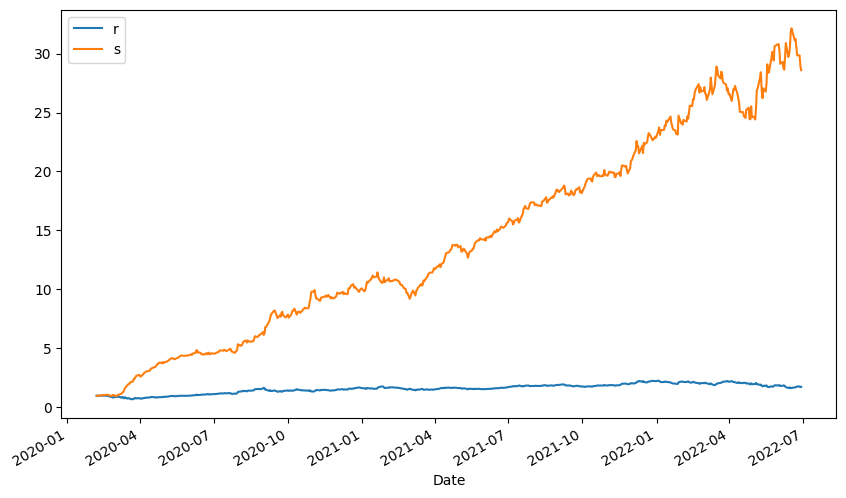

In [67]:
train_df["p"] = np.where(model.predict(train_df_[cols]) > 0.5, 1, 0)
train_df["p"] = np.where(train_df["p"] == 1, 1, -1)
train_df["s"] = train_df["p"] * train_df["r"]
train_df[["r", "s"]].cumsum().apply(np.exp).plot(figsize=(10, 6))
# r -> no strategy applied. Just price movement.
# s -> with strategy suggested by the model.
plt.show()

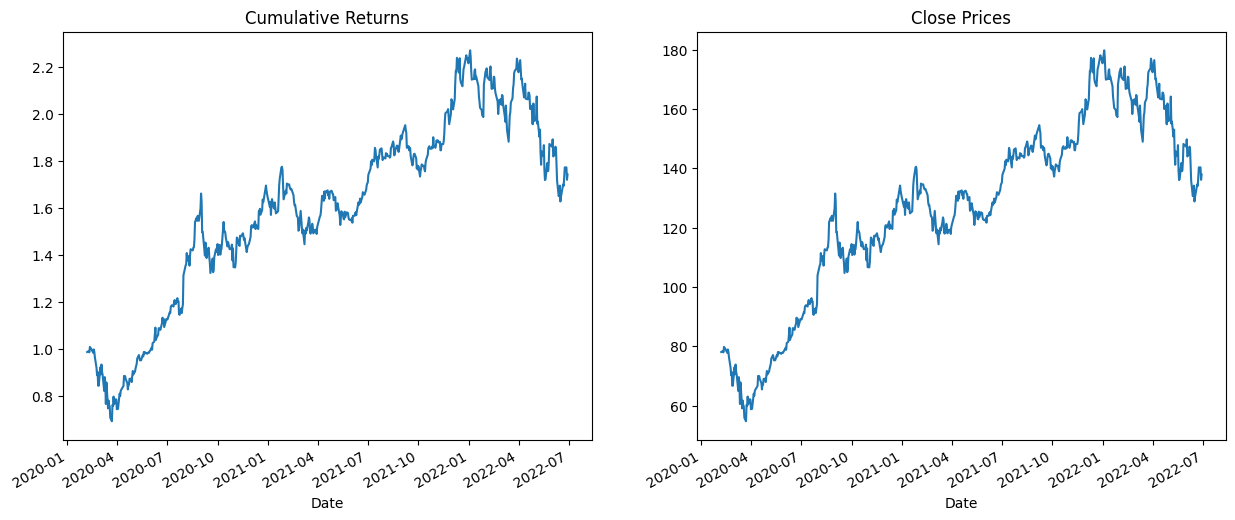

In [68]:
# Just to check stock price movement trajectory
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
train_df["r"].cumsum().apply(np.exp).plot(ax=ax[0], title="Cumulative Returns")
train_df["Close"].plot(ax=ax[1], title="Close Prices")
plt.show()


---
### Side research
Here, the first step to make it close to real market trading is see whether the model can predict not just binary precition but just short or long when the signal is strong enough. To do that, we need a helper function. Below is a test snippest to implement this.

In [47]:
# Toy data
t_df = pd.DataFrame({"a": [1,2,3]})
t_df

,a
0,1
1,2
2,3


In [48]:
def convert_a_c(x):
    if x == 1:
        return True
    elif x == 3:
        return False
    else:
        return x

In [49]:
t_df["b"] = t_df["a"].map(convert_a_c)

In [50]:
t_df

,a,b
0,1,True
1,2,2
2,3,False


---

## Transitioning from Binary to Ternary

In this section, I fine-tune my stock market prediction strategy. My func_decision function now provides nuanced signals of -1 (short), 0 (neutral), or 1 (long) based on the model's confidence. I act only on strong indications, with thresholds set at 0.3 for short and 0.7 for long. The plotted signals on the stock price chart visually demonstrate the effectiveness of this refined approach, offering a more precise decision-making process in navigating the complexities of the stock market.

In [55]:
# Decision only when indication is strong
def func_decision(x):
    if x < 0.3:
        return -1
    elif x > 0.7:
        return 1
    else:
        return 0


train_df["p"] = model.predict(train_df_[cols])
train_df["p_"] = train_df["p"].map(func_decision)

19/19 [==============================] - 0s 439us/step


In [56]:
train_df["p_"].value_counts()
# df['p'].hist()

p_
 0    503
 1     63
-1     37
Name: count, dtype: int64

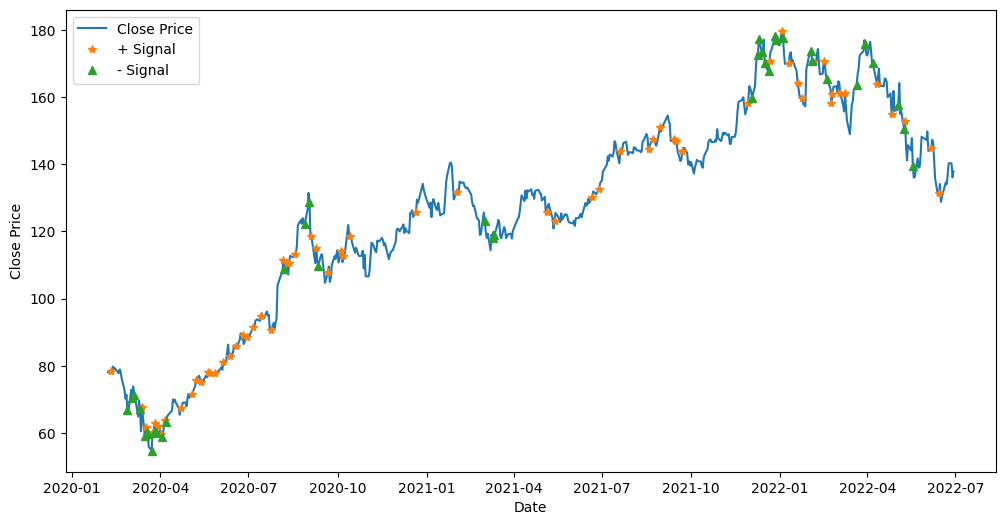

In [69]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(train_df["Close"], label='Close Price')
plt.plot(train_df[train_df["p_"] == 1]["Close"], "*", label='+ Signal')
plt.plot(train_df[train_df["p_"] == -1]["Close"], "^", label='- Signal')

# Add labels for the x and y axes
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()

plt.show()

In the chart featuring signal indicators, the model appears to suggest accurate entry and exit points. However, despite the promising outlook portrayed by the signal-marked chart, the performance on the test data is notably disappointing, with just over 50% predictive power. Several factors contribute to this subpar result, primarily rooted in the idiosyncrasies of price data and opportunities for enhancement in the neural network model.

In the upcoming series, I will address these issues systematically, aiming to refine and optimize the model's performance step by step
